# Call consensus sequences for viral barcodes in each cell
This Python Jupyter notebook corrects/calls consensus viral barcodes in each cell. Viral barcodes are input as UMI count data, assigned to a cell barcode and gene. The notebook uses UMI tools to correct the viral barcodes for each cell; this provides a set of consensus viral barcodes within each cell. The notebook outputs the corrected viral barcode counts and a whitelist of viral barcodes identified on each segment.

## Notes about UMI_tools
* Using directional adjacency method. This has [been demonstrated on simulated data](https://cgatoxford.wordpress.com/2015/08/14/unique-molecular-identifiers-the-problem-the-solution-and-the-proof/) to produce a more accurate estimate of true UMI number than other heuristics.
* Sequence must be input as byte. See definition here: https://stackoverflow.com/questions/6269765/what-does-the-b-character-do-in-front-of-a-string-literal
* The corrected barcode is returned as the first barcode in the group list. See umi_tools API documentation: https://umi-tools.readthedocs.io/en/latest/API.html

Import Python modules:

In [1]:
import gzip

from IPython.display import display

from dms_variants.constants import CBPALETTE

import numpy as np

import pandas as pd

import plotnine as p9

from umi_tools import UMIClusterer

Get `snakemake` variables [as described here](https://snakemake.readthedocs.io/en/stable/snakefiles/rules.html#jupyter-notebook-integration):

In [2]:
viral_bc_by_cell = 'results/viral_fastq10x/scProgenyProduction_trial2_viral_bc_by_cell.csv.gz'
expt = 'scProgenyProduction_trial2'

Set plot style

In [3]:
p9.theme_set(p9.theme_classic())

Import barcode data

In [4]:
viral_bc_df = pd.read_csv(gzip.open(viral_bc_by_cell))
display(viral_bc_df)

,gene,cell_barcode,viral_barcode,count
0,fluHA,AAACCCAAGTAGGTTA,ACGTTATTGATTGAGA,1
1,fluHA,AAACCCAAGTAGGTTA,AGAATCGACACATGTC,14
2,fluHA,AAACCCAAGTAGGTTA,AGCCATAGTCTAAAGG,7
3,fluHA,AAACCCAAGTAGGTTA,AGCCATAGTCTACAGG,1
4,fluHA,AAACCCAAGTAGGTTA,AGGATGATTTTTTTAT,1
...,...,...,...,...
94893,fluNA,TTTGTTGTCTAGGAAA,GAACCCGAAGGGGAAT,1
94894,fluNA,TTTGTTGTCTAGGAAA,GAACCCGATGGGGAAT,25
94895,fluNA,TTTGTTGTCTAGGAAA,TAAGGTAAAATAATAG,1
94896,fluNA,TTTGTTGTCTAGGAAA,TAAGGTATAATTCTAG,4


Cluster barcodes within each cell

In [5]:
clusterer = UMIClusterer(cluster_method="directional")

lookup_list = []

for (cell_barcode, gene), df in (viral_bc_df
                                .groupby(['cell_barcode',
                                          'gene'])):
    # Convert dataframe to dictionary. Dict requried input for umi_tools.
    viral_bc_dict = (df[['viral_barcode', 'count']]
                     .set_index('viral_barcode')
                     .to_dict(orient='dict'))
    viral_bc_dict = viral_bc_dict['count']

    # Convert barcode strings to byte. Byte required dtype for umi_tools.
    byte_dict = {}
    for key, value in viral_bc_dict.items():
        byte_dict[key.encode("utf-8")] = float(value)

    # Cluster barcodes
    bc_groups = clusterer(byte_dict, threshold=1)
    groups_df = pd.DataFrame(bc_groups)
    groups_df = (groups_df
                 .stack()
                 .str
                 .decode('utf-8')
                 .unstack())  # Convert bytes back to string
    groups_df = groups_df.rename(columns={0: 'corrected_viral_bc'})
    groups_df = groups_df.set_index('corrected_viral_bc', drop=False)

    # Generate lookup table for this sample
    temp_lookup_df = (groups_df.melt(ignore_index=False,
                                     value_name='original_viral_bc')
                      ['original_viral_bc']
                      .dropna()
                      .reset_index())
    temp_lookup_df['gene'] = gene
    temp_lookup_df['cell_barcode'] = cell_barcode
#     temp_lookup_df['corrected'] = (temp_lookup_df['corrected_viral_bc']
#                                    != temp_lookup_df['original_viral_bc'])
    lookup_list.append(temp_lookup_df)

lookup_df = pd.concat(lookup_list)
display(lookup_df)

,corrected_viral_bc,original_viral_bc,gene,cell_barcode
0,CTTAACTGTATATTCG,CTTAACTGTATATTCG,fluHA,AAACCCAAGTAGGTTA
1,TGTAAATAGAGTTCGC,TGTAAATAGAGTTCGC,fluHA,AAACCCAAGTAGGTTA
2,AGAATCGACACATGTC,AGAATCGACACATGTC,fluHA,AAACCCAAGTAGGTTA
3,TCTTAAGTATATCAGA,TCTTAAGTATATCAGA,fluHA,AAACCCAAGTAGGTTA
4,CACGGATGGTGTACGA,CACGGATGGTGTACGA,fluHA,AAACCCAAGTAGGTTA
...,...,...,...,...
0,GAACCCGATGGGGAAT,GAACCCGATGGGGAAT,fluNA,TTTGTTGTCTAGGAAA
1,TGTTGGGCTTTAAGCA,TGTTGGGCTTTAAGCA,fluNA,TTTGTTGTCTAGGAAA
2,TAAGGTATAATTCTAG,TAAGGTATAATTCTAG,fluNA,TTTGTTGTCTAGGAAA
3,TAAGGTAAAATAATAG,TAAGGTAAAATAATAG,fluNA,TTTGTTGTCTAGGAAA


Merge corrected barcode data with barcode frequency data.

In [6]:
viral_bc_df = pd.merge(viral_bc_df,
                       lookup_df,
                       left_on=['cell_barcode', 'gene', 'viral_barcode'],
                       right_on=['cell_barcode', 'gene', 'original_viral_bc'])
viral_bc_df = viral_bc_df.drop('viral_barcode', axis=1)

Aggregate counts on corrected barcodes.

In [7]:
viral_bc_df = pd.merge(viral_bc_df,
                       (viral_bc_df
                        .groupby(['cell_barcode',
                                  'gene',
                                  'corrected_viral_bc'])
                        .sum()
                        .reset_index()),
                       on=['cell_barcode', 'gene', 'corrected_viral_bc'],
                       suffixes=['_original_viral_bc', '_corrected_viral_bc'])

Annotate barcodes as corrected.

In [8]:
viral_bc_df['corrected'] = (viral_bc_df['corrected_viral_bc']
                            != viral_bc_df['original_viral_bc'])

display(viral_bc_df)

,gene,cell_barcode,count_original_viral_bc,corrected_viral_bc,original_viral_bc,count_corrected_viral_bc,corrected
0,fluHA,AAACCCAAGTAGGTTA,1,ACGTTATTGATTGAGA,ACGTTATTGATTGAGA,1,False
1,fluHA,AAACCCAAGTAGGTTA,14,AGAATCGACACATGTC,AGAATCGACACATGTC,14,False
2,fluHA,AAACCCAAGTAGGTTA,7,AGCCATAGTCTAAAGG,AGCCATAGTCTAAAGG,8,False
3,fluHA,AAACCCAAGTAGGTTA,1,AGCCATAGTCTAAAGG,AGCCATAGTCTACAGG,8,True
4,fluHA,AAACCCAAGTAGGTTA,1,AGGATGATTTTTTTGT,AGGATGATTTTTTTAT,5,True
...,...,...,...,...,...,...,...
94893,fluNA,TTTGTTGTCTAGGAAA,1,GAACCCGATGGGGAAT,GAACCCGAAGGGGAAT,26,True
94894,fluNA,TTTGTTGTCTAGGAAA,25,GAACCCGATGGGGAAT,GAACCCGATGGGGAAT,26,False
94895,fluNA,TTTGTTGTCTAGGAAA,1,TAAGGTAAAATAATAG,TAAGGTAAAATAATAG,1,False
94896,fluNA,TTTGTTGTCTAGGAAA,4,TAAGGTATAATTCTAG,TAAGGTATAATTCTAG,4,False


Plot number of UMIs that underwent correction:

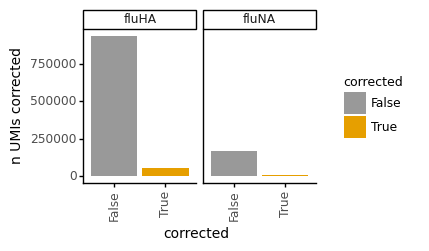

In [9]:
fig = (p9.ggplot(viral_bc_df, p9.aes(x='corrected',
                                     y='count_original_viral_bc',
                                     fill='corrected')) +
       p9.geom_bar(stat='identity') +
       p9.ylab('n UMIs corrected') +
       p9.facet_grid('~gene') +
       p9.scale_x_discrete(limits=(viral_bc_df['corrected']
                                   .unique()
                                   .tolist())) +  # Order categorical values
       p9.theme(figure_size=(1.5*(viral_bc_df['gene'].nunique()),
                             2),
                axis_text_x=p9.element_text(angle=90),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_fill_manual(CBPALETTE[0:]))

# show plot
fig.draw()

Plot fraction of UMIs corrected **within each cell**.

corrected,cell_barcode,gene,False,True,ratio
0,AAACCCAAGTAGGTTA,fluHA,111.0,5.0,0.043103
1,AAACCCAAGTAGGTTA,fluNA,30.0,1.0,0.032258
2,AAACCCACAAGGCCTC,fluHA,2.0,0.0,0.000000
3,AAACCCACAAGGCCTC,fluNA,14.0,2.0,0.125000
4,AAACCCACACACACGC,fluHA,194.0,14.0,0.067308
...,...,...,...,...,...
11193,TTTGGTTGTTAAGCAA,fluNA,1.0,0.0,0.000000
11194,TTTGTTGCATGTGGTT,fluHA,88.0,2.0,0.022222
11195,TTTGTTGCATGTGGTT,fluNA,46.0,1.0,0.021277
11196,TTTGTTGTCTAGGAAA,fluHA,68.0,4.0,0.055556


/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


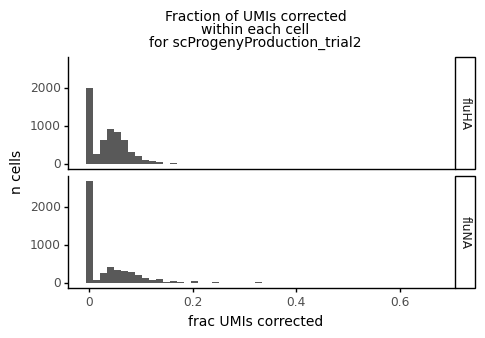

In [10]:
correct_ratios_df = (viral_bc_df
                     .groupby(['cell_barcode',
                               'gene',
                               'corrected'])
                     .agg(func=np.sum)
                     .reset_index()
                     .pivot_table(index=['cell_barcode','gene'],
                                  columns='corrected',
                                  values='count_original_viral_bc')
                     .reset_index()
                     .fillna(0))

correct_ratios_df['ratio'] = (correct_ratios_df[True] /
                              (correct_ratios_df[True] +
                               correct_ratios_df[False]))

display(correct_ratios_df)

fig = (p9.ggplot(correct_ratios_df, p9.aes(x='ratio')) +
       p9.ggtitle('Fraction of UMIs corrected\n'
                  'within each cell\n'
                  f'for {expt}') +
       p9.geom_histogram(bins=50) +
       p9.facet_grid('gene~') +
       p9.theme(figure_size=(5,3),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_fill_manual(CBPALETTE[0:]) +
       p9.labs(x='frac UMIs corrected',
               y='n cells')
      )

# show plot
fig.draw()

Plot number of barcodes identified in each cell, before and after correction.

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 61 rows containing non-finite values.
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_histogram : Removed 8 rows containing missing values.


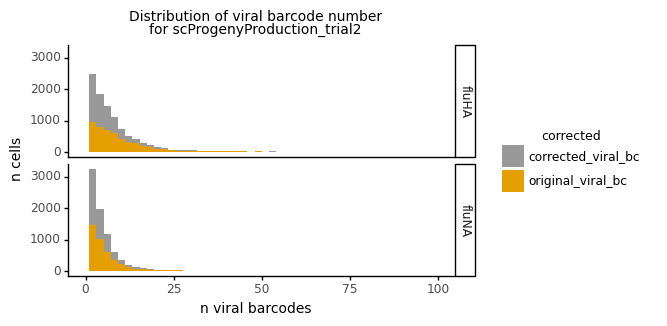

In [11]:
fig = (p9.ggplot((viral_bc_df
                  .groupby(['cell_barcode','gene'])
                  .nunique()
                  .reset_index()
                  [['cell_barcode',
                    'gene',
                    'original_viral_bc',
                    'corrected_viral_bc']]
                  .melt(id_vars=['cell_barcode', 'gene'], 
                        var_name="corrected", 
                        value_name="n_barcodes")
                  ),
                 p9.aes(x='n_barcodes',
                        fill='corrected')) +
       p9.ggtitle('Distribution of viral barcode number\n'
                  f'for {expt}') +
       p9.geom_histogram(bins=50) +
       p9.facet_grid('gene~') +
       p9.theme(figure_size=(5,3),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_fill_manual(CBPALETTE[0:]) +
       p9.labs(x='n viral barcodes',
               y='n cells') +
       p9.xlim(0,100))

# show plot
fig.draw()

Plot relationship between numbers of barcodes on HA and NA segments.

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 3076 rows containing missing values.


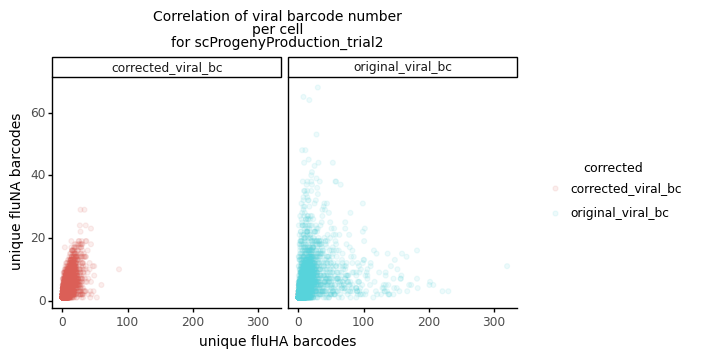

In [12]:
fig = (p9.ggplot((viral_bc_df
                  .groupby(['cell_barcode','gene'])
                  .nunique()
                  .reset_index()
                  [['cell_barcode',
                    'gene',
                    'original_viral_bc',
                    'corrected_viral_bc']]
                  .melt(id_vars=['cell_barcode', 'gene'], 
                        var_name="corrected", 
                        value_name="n_barcodes")
                  .pivot_table(index=['cell_barcode','corrected'],
                               columns='gene',
                               values='n_barcodes')
                  .reset_index()
                  ),
                 p9.aes(x='fluHA',
                        y='fluNA',
                        color='corrected')) +
       p9.ggtitle('Correlation of viral barcode number\n'
                  'per cell\n'
                  f'for {expt}') +
       p9.geom_point(alpha=0.1) +
       p9.facet_grid('~corrected') +
       p9.theme(figure_size=(6,3),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.labs(x='unique fluHA barcodes',
               y='unique fluNA barcodes'))

# show plot
fig.draw()

Zoom in on cells with small, more realistic numbers of barcodes.

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 3540 rows containing missing values.


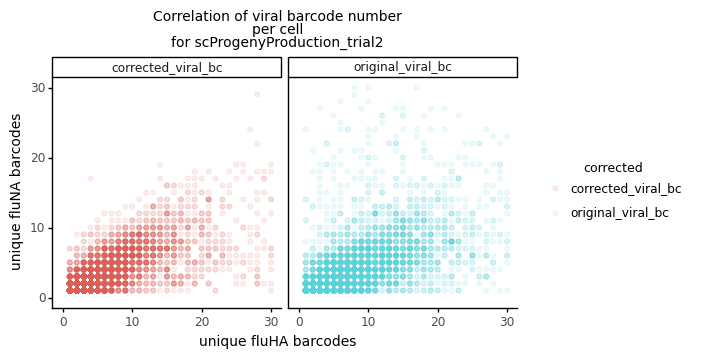

In [13]:
fig = (p9.ggplot((viral_bc_df
                  .groupby(['cell_barcode','gene'])
                  .nunique()
                  .reset_index()
                  [['cell_barcode',
                    'gene',
                    'original_viral_bc',
                    'corrected_viral_bc']]
                  .melt(id_vars=['cell_barcode', 'gene'], 
                        var_name="corrected", 
                        value_name="n_barcodes")
                  .pivot_table(index=['cell_barcode','corrected'],
                               columns='gene',
                               values='n_barcodes')
                  .reset_index()
                  ),
                 p9.aes(x='fluHA',
                        y='fluNA',
                        color='corrected')) +
       p9.ggtitle('Correlation of viral barcode number\n'
                  'per cell\n'
                  f'for {expt}') +
       p9.geom_point(alpha=0.1) +
       p9.facet_grid('~corrected') +
       p9.theme(figure_size=(6,3),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.labs(x='unique fluHA barcodes',
               y='unique fluNA barcodes') +
       p9.xlim(0,30) +
       p9.ylim(0,30))

# show plot
fig.draw()

Filter barcodes with only 1 corrected count.

In [14]:
threshold = 2

viral_bc_df['filtered'] = (viral_bc_df['count_corrected_viral_bc'] <
                           threshold)

display(viral_bc_df['filtered'].value_counts())

False    72288
True     22610
Name: filtered, dtype: int64

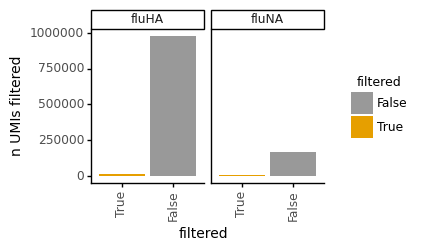

In [15]:
fig = (p9.ggplot(viral_bc_df, p9.aes(x='filtered',
                                     y='count_original_viral_bc',
                                     fill='filtered')) +
       p9.geom_bar(stat='identity') +
       p9.ylab('n UMIs filtered') +
       p9.facet_grid('~gene') +
       p9.scale_x_discrete(limits=(viral_bc_df['filtered']
                                   .unique()
                                   .tolist())) +  # Order categorical values
       p9.theme(figure_size=(1.5*(viral_bc_df['gene'].nunique()),
                             2),
                axis_text_x=p9.element_text(angle=90),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_fill_manual(CBPALETTE[0:]))

# show plot
fig.draw()

filtered,cell_barcode,gene,False,True,ratio
0,AAACCCAAGTAGGTTA,fluHA,113.0,3.0,0.025862
1,AAACCCAAGTAGGTTA,fluNA,29.0,2.0,0.064516
2,AAACCCACAAGGCCTC,fluHA,2.0,0.0,0.000000
3,AAACCCACAAGGCCTC,fluNA,16.0,0.0,0.000000
4,AAACCCACACACACGC,fluHA,202.0,6.0,0.028846
...,...,...,...,...,...
11193,TTTGGTTGTTAAGCAA,fluNA,0.0,1.0,1.000000
11194,TTTGTTGCATGTGGTT,fluHA,86.0,4.0,0.044444
11195,TTTGTTGCATGTGGTT,fluNA,43.0,4.0,0.085106
11196,TTTGTTGTCTAGGAAA,fluHA,68.0,4.0,0.055556


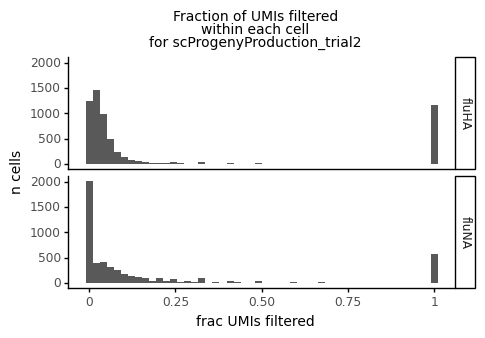

In [16]:
filtered_ratios_df = (viral_bc_df
                     .groupby(['cell_barcode',
                               'gene',
                               'filtered'])
                     .agg(func=np.sum)
                     .reset_index()
                     .pivot_table(index=['cell_barcode','gene'],
                                  columns='filtered',
                                  values='count_original_viral_bc')
                     .reset_index()
                     .fillna(0))

filtered_ratios_df['ratio'] = (filtered_ratios_df[True] /
                              (filtered_ratios_df[True] +
                               filtered_ratios_df[False]))

display(filtered_ratios_df)

fig = (p9.ggplot(filtered_ratios_df, p9.aes(x='ratio')) +
       p9.ggtitle('Fraction of UMIs filtered\n'
                  'within each cell\n'
                  f'for {expt}') +
       p9.geom_histogram(bins=50) +
       p9.facet_grid('gene~') +
       p9.theme(figure_size=(5,3),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.labs(x='frac UMIs filtered',
               y='n cells')
      )

# show plot
fig.draw()

Plot viral barcodes remaining after filtering:

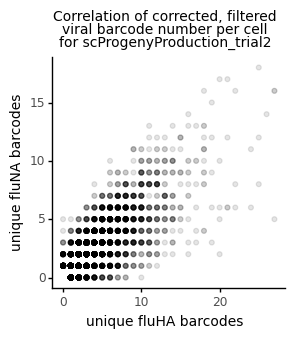

In [34]:
fig = (p9.ggplot((viral_bc_df
                  .query('(filtered == False)')
                  .groupby(['cell_barcode','gene',])
                  .nunique()
                  .reset_index()
                   [['cell_barcode',
                    'gene',
                    'corrected_viral_bc']]
                  .pivot_table(index=['cell_barcode',],
                               columns='gene',
                               values='corrected_viral_bc')
                  .fillna(0)
                  .reset_index()
                  ),
                 p9.aes(x='fluHA',
                        y='fluNA')) +
       p9.ggtitle('Correlation of corrected, filtered\n'
                  'viral barcode number per cell\n'
                  f'for {expt}') +
       p9.geom_point(alpha=0.1) +
       p9.theme(figure_size=(3,3),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.labs(x='unique fluHA barcodes',
               y='unique fluNA barcodes'))

# show plot
fig.draw()